# Weather Prediction Project

## Project Overview

This project aims to build and evaluate binary classification models to predict whether or not it will rain tomorrow based on historical weather data. The process involves loading the data, performing extensive data preprocessing (handling missing values, encoding categorical features, handling temporal features), splitting the data for training, validation, and testing, training multiple machine learning models, and evaluating their performance using various metrics and visualizations.

## Dataset

The dataset used in this project is the **Weather Dataset** from Kaggle, available at [https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package). It contains daily weather observations from various locations across Australia. The target variable is `RainTomorrow`, which indicates whether it rained on the following day.

## Steps Performed

1.  **Data Loading**: The dataset was downloaded from Kaggle using the `opendatasets` library and loaded into a pandas DataFrame.
2.  **Initial Data Exploration**: Performed an initial overview of the data, including checking data types, non-null counts, descriptive statistics, and the percentage of missing values for each column.
3.  **Handling Missing Values**:
    *   Rows with missing values in the target variable (`RainTomorrow`) and `RainToday` were removed.
    *   Columns with a high percentage of missing values (`Evaporation`, `Cloud9am`) were dropped after examining their relationship with the target.
    *   Missing values in the remaining numerical columns were imputed with the median.
    *   Missing values in the remaining categorical columns were imputed with the mode.
4.  **Handling Temporal Features**:
    *   The `Date` column was converted to datetime objects.
    *   `Year` and `Month` were extracted from the `Date` column.
    *   A `TimeIndex` feature was created from the `Year` column (Year - Baseline Year). We commented this section out later as it didn't increase accuray.
    *   Cyclical features (`Month_sin`, `Month_cos`) were created from the `Month` column.
    *   The original `Date`, and `Month` columns were dropped. `Year` column was needed to divide the data for training\val\test sets which is discussed later.
5.  **Encoding Categorical Features**: Categorical features (`Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm`, `RainToday`) were One-Hot Encoded.
6.  **Data Scaling**: Numerical features were scaled using `StandardScaler`.
7.  **Data Splitting**: The data was split into training, validation, and test sets based on the `Year` column to maintain temporal order (Train: 2007-2014, Val: 2015-2016, Test: 2017).
8.  **Model Evaluation**: Multiple binary classification models (Logistic Regression, Decision Tree, Random Forest) were evaluated on the training and validation sets using a custom evaluation function.
9.  **Model Analysis**: The performance of the models was analyzed using:
    *   Feature Importance (for Random Forest)
    *   Confusion Matrix (for Random Forest)
    *   Classification Report (for Random Forest)
    *   ROC Curves and AUC scores (for all models), visualized interactively using Plotly.

## Key Findings

*   The Random Forest model achieved the highest performance among the evaluated models based on the ROC AUC score (approximately 0.8681), indicating good discriminatory power.
*   Feature importance analysis showed that `Humidity3pm`, `Sunshine`, `Pressure3pm`, and `Humidity9am` were among the most important features for the Random Forest model.
*   The confusion matrix and classification report provided detailed insights into the Random Forest model's performance on predicting both rainy and non-rainy days.

## Next Steps (Potential)

*   Hyperparameter tune the best-performing model (Random Forest).
*   Evaluate the final selected model on the unseen test set (2017 data).
*   Explore other advanced classification models.
*   Implement a scikit-learn pipeline for streamlined preprocessing and modeling.
*   Save or deploy the trained model.

# **Download the data from Kaggle**

In [84]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package'

In [85]:
#To avoid uploading Kaggle API key document to Collab every time we want to run this code, we want to ceate a secret key in Collab.
from google.colab import userdata
import os
import json

# Access the KAGGLE_KEY secret
kaggle_secret = userdata.get('KAGGLE_API')

# The kaggle_secret variable now holds the content of your kaggle.json file.
# You can print it to verify (be careful not to share your key publicly!)
#print(kaggle_secret)

# Parse the JSON string to get username and key
kaggle_creds = json.loads(kaggle_secret)

# Set environment variables for opendatasets to use
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

In [86]:
#Download the dataset using opendatasets
# The opendatasets library will now use the environment variables for authentication

import os
#print("KAGGLE_USERNAME:", os.environ.get('KAGGLE_USERNAME'))
#print("KAGGLE_KEY:", os.environ.get('KAGGLE_KEY'))

od.download(dataset_url)

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [87]:
#Check the downloaded dataset
import os
os.listdir('./weather-dataset-rattle-package')

['weatherAUS.csv']

# **General Overview of Data:**

In [88]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('./weather-dataset-rattle-package/weatherAUS.csv')

raw_df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ...        71.0   
1            NaN         WNW           44.0        NNW  ...        44.0   
2            NaN         WSW           46.0          W  ...        38.0   
3            NaN          NE           24.0         SE  ...        45.0   
4            NaN           W           41.0        ENE  ...        82.0   
...          ...         ...            ...        ...  ...         ...   
145455       NaN           E           31.0         SE  ...        51.0   
145456       NaN         NNW           22.0         SE  ...        56.0   
145457       NaN           N           37.0         SE  ...        53.0   
145458       NaN          SE           28.0        SSE  ...        51.0   
145459       NaN         NaN            NaN        ESE  ...        62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0              22.0       1007.7       1007.1       8.0       NaN     16.9   
1              25.0       1010.6       1007.8       NaN       NaN     17.2   
2              30.0       1007.6       1008.7       NaN       2.0     21.0   
3              16.0       1017.6       1012.8       NaN       NaN     18.1   
4              33.0       1010.8       1006.0       7.0       8.0     17.8   
...             ...          ...          ...       ...       ...      ...   
145455         24.0       1024.6       1020.3       NaN       NaN     10.1   
145456         21.0       1023.5       1019.1       NaN       NaN     10.9   
145457         24.0       1021.0       1016.8       NaN       NaN     12.5   
145458         24.0       1019.4       1016.5       3.0       2.0     15.1   
145459         36.0       1020.2       1017.9       8.0       8.0     15.0   

        Temp3pm  RainToday  RainTomorrow  
0          21.8         No            No  
1          24.3         No            No  
2          23.2         No            No  
3          26.5         No            No  
4          29.7         No            No  
...         ...        ...           ...  
145455     22.4         No            No  
145456     24.5         No            No  
145457     26.1         No            No  
145458     26.0         No            No  
145459     20.9         No           NaN  

[145460 rows x 23 columns]

In [89]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [90]:
raw_df.describe()
#Only available for numeric columns

MinTemp        MaxTemp       Rainfall   Evaporation  \
count  143975.000000  144199.000000  142199.000000  82670.000000   
mean       12.194034      23.221348       2.360918      5.468232   
std         6.398495       7.119049       8.478060      4.193704   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.900000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  75625.000000  135197.000000  143693.000000  142398.000000   
mean       7.611178      40.035230      14.043426      18.662657   
std        3.785483      13.607062       8.915375       8.809800   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.800000      31.000000       7.000000      13.000000   
50%        8.400000      39.000000      13.000000      19.000000   
75%       10.600000      48.000000      19.000000      24.000000   
max       14.500000     135.000000     130.000000      87.000000   

         Humidity9am    Humidity3pm   Pressure9am    Pressure3pm  \
count  142806.000000  140953.000000  130395.00000  130432.000000   
mean       68.880831      51.539116    1017.64994    1015.255889   
std        19.029164      20.795902       7.10653       7.037414   
min         0.000000       0.000000     980.50000     977.100000   
25%        57.000000      37.000000    1012.90000    1010.400000   
50%        70.000000      52.000000    1017.60000    1015.200000   
75%        83.000000      66.000000    1022.40000    1020.000000   
max       100.000000     100.000000    1041.00000    1039.600000   

           Cloud9am      Cloud3pm        Temp9am       Temp3pm  
count  89572.000000  86102.000000  143693.000000  141851.00000  
mean       4.447461      4.509930      16.990631      21.68339  
std        2.887159      2.720357       6.488753       6.93665  
min        0.000000      0.000000      -7.200000      -5.40000  
25%        1.000000      2.000000      12.300000      16.60000  
50%        5.000000      5.000000      16.700000      21.10000  
75%        7.000000      7.000000      21.600000      26.40000  
max        9.000000      9.000000      40.200000      46.70000

In [91]:
raw_df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [92]:
# Calculate the percentage of missing values for each column
missing_percentage = raw_df.isnull().sum() / len(raw_df) * 100

# Display columns with missing values and their percentages
print("Percentage of missing values per column:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))

Percentage of missing values per column:
Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
WindSpeed9am      1.214767
Temp9am           1.214767
MinTemp           1.020899
MaxTemp           0.866905
dtype: float64


# **Handle Missing Target Values**

For numerical columns with missing values, we can use imputation techniques like replacing NaNs with the mean, median, or a constant value.

For categorical columns, we could replace NaNs with the mode or a placeholder like 'Unknown'.

The 'RainTomorrow' column is our target variable, and having missing values in it means we can't use those rows for training our model.

Let's prioritize handling the missing values in the 'RainTomorrow' column first. A common approach for a classification target variable with a small percentage of missing values is to remove the rows where the target is missing. This is because imputing a binary target can be tricky and might introduce bias.

After handling the 'RainTomorrow' column, we can then proceed with handling the missing values in the other features.

Let's see if 'RainToday' has influence on 'RainTomorrow'. If it does, we might also have to filter out raws with missing values of 'RainToday'.

In [93]:
#Create a copy of df for handelling missing target values:
df=raw_df.copy()

# Encode 'RainToday' and 'RainTomorrow'
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

# Display the first few rows to check the encoding
#display(df[['RainToday', 'RainTomorrow']].head())

In [94]:
# Calculate the correlation between 'RainToday' and 'RainTomorrow'
correlation = df['RainToday'].corr(df['RainTomorrow'])

# Display the correlation
print(f"Correlation between RainToday and RainTomorrow: {correlation}")

#Output:
#Correlation between RainToday and RainTomorrow: 0.3130967455089659

Correlation between RainToday and RainTomorrow: 0.3130967455089659


Now that 'RainToday' and 'RainTomorrow' are encoded as numerical values, we can calculate the correlation between them.

The correlation between 'RainToday' and 'RainTomorrow' is approximately 0.313. This indicates a weak positive correlation. It suggests that there is a tendency for it to rain tomorrow if it rained today, but the relationship is not very strong.

Given this weak correlation and the fact that 'RainToday' has a relatively small percentage of missing values (2.24%), removing the rows with missing 'RainToday' would be a reasonable approach. This will ensure that we have complete data for this feature without introducing potential bias from imputation.

Let's remove the rows where 'RainToday' is missing.

In [95]:
# Drop rows where either 'RainToday' or 'RainTomorrow' is missing
df.dropna(subset=['RainToday', 'RainTomorrow']).copy()

# Calculate the percentage of missing values for each column in the updated DataFrame
missing_percentage_after_drop = df.isnull().sum() / len(df) * 100

# Display columns with missing values and their percentages
print("Percentage of missing values per column after dropping missing RainToday and RainTomorrow:")
print(missing_percentage_after_drop[missing_percentage_after_drop >= 0].sort_values(ascending=False))

Percentage of missing values per column after dropping missing RainToday and RainTomorrow:
Sunshine         48.009762
Evaporation      43.166506
Cloud3pm         40.807095
Cloud9am         38.421559
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
WindSpeed9am      1.214767
Temp9am           1.214767
MinTemp           1.020899
MaxTemp           0.866905
Date              0.000000
Location          0.000000
dtype: float64


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Now that we have the updated percentages of missing values, we can see which columns still have missing data and decide on how to handle them.

From the output of the last cell, we can see that columns like 'Sunshine', 'Evaporation', 'Cloud3pm', and 'Cloud9am' still have a significant percentage of missing values (over 37%).

For columns with a high percentage of missing values, we have a few options:

*  Drop the columns: If these columns are not considered crucial for predicting 'RainTomorrow' or if imputing such a large amount of missing data might introduce too much noise or bias, we could drop these columns entirely.
*   Impute with a placeholder: For categorical columns with high missingness, we could impute with a placeholder like 'Unknown'. For numerical columns, imputing with the mean or median might not be appropriate if the missingness is not random.

For columns with a lower percentage of missing values (e.g., 'MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', etc.), imputation is generally a reasonable approach.

# **Exploratory Analysis using Visualization (Individual columns)**

In [97]:
import matplotlib.pyplot as plt
import plotly.express as px

In [98]:
px.histogram(df, x='Location', color='RainToday')

*   Even distribution of data for almost all locations (~3000 data points)
*   For all location, more than triple days where it didn't rain, than it rained.
*   Some weather stations (Nhil, Uluru, Katherine) has half of data compared to rest weather stations.


In [99]:
px.histogram(df, x='RainToday', color='RainTomorrow')

*   If it didn't rain today (left side), it's unlikely to rain tomorrow.
*   If it rained today, it's 50-50% chances that it rain tomorrow as well.


Handle missing Values:

It's a good idea to explore the relationship between 'Sunshine', 'Evaporation', 'Cloud9am', and 'Cloud3pm' columns and the target variable 'RainTomorrow' before making a decision to drop them. Even with a high percentage of missing values, they might still contain some predictive power.

We can visualize the relationship between these features and 'RainTomorrow'. Since 'RainTomorrow' is a binary variable, we can use visualizations like box plots (for numerical features) or bar plots (for categorical features, although these are all numerical) to see if there are noticeable differences in the distribution of these features based on whether it rained tomorrow or not.


In [100]:
# Create interactive box plot for Sunshine vs RainTomorrow
fig_sunshine = px.box(df, x='RainTomorrow', y='Sunshine', title='Interactive Box Plot of Sunshine vs RainTomorrow')
fig_sunshine.show()

# Create interactive box plot for Evaporation vs RainTomorrow
fig_evaporation = px.box(df, x='RainTomorrow', y='Evaporation', title='Interactive Box Plot of Evaporation vs RainTomorrow')
fig_evaporation.show()

# Create interactive box plot for Cloud9am vs RainTomorrow
fig_cloud9am = px.box(df, x='RainTomorrow', y='Cloud9am', title='Interactive Box Plot of Cloud9am vs RainTomorrow')
fig_cloud9am.show()

# Create interactive box plot for Cloud3pm vs RainTomorrow
fig_cloud3pm = px.box(df, x='RainTomorrow', y='Cloud3pm', title='Interactive Box Plot of Cloud3pm vs RainTomorrow')
fig_cloud3pm.show()

**Observations**

**'Sunshine'**:
*   Days without rain tomorrow typically have significantly more sunshine, with a median around 8-10 hours.
*   Days with rain tomorrow have considerably less sunshine, with a median around 1-3 hours, indicating a strong inverse relationship.

Let's keep sunshine

**'Evaporation'**:
*   Very weak trend. Meadian of both columns are similar.
*   lot of outliers without any clear trend. Let's remove Evaporatuion.

let's consider dropping this column for now to simplify the dataset and avoid potential issues with imputing such a large amount of data.

**'Cloud9am' vs 'Cloud3pm'**:
*   Q1 Difference: For 'RainTomorrow' = Yes, the first quartile (Q1) for 'Cloud3pm' appears to be higher (around 6) compared to 'Cloud9am' (around 5). This means that for days with rain tomorrow, at least 75% of the time, the cloud cover at 3 pm was 6 octas or higher, while at 9 am, it was 5 octas or higher. This is a factor and suggests that cloud cover might be building throughout the day on days that precede rain.

*   Physical Intuition: 'Cloud3pm' is a better indicator because it's closer in time to "tomorrow" is also a very valid point. Weather patterns evolve, and the conditions later in the day might indeed be more indicative of the immediate future weather than conditions earlier in the day.

Considering these factors, while both show a strong relationship, the slightly higher Q1 for 'Cloud3pm' when it rains tomorrow, combined with the physical intuition that afternoon conditions might be more predictive of rain tomorrow, suggests that 'Cloud3pm' might indeed be a slightly better indicator than 'Cloud9am',


In [101]:
# Drop the 'Evaporation' and 'Cloud9am' columns
df = df.drop(['Evaporation', 'Cloud9am'], axis=1)

# Display the first few rows and check the shape to confirm the columns are dropped
print("DataFrame after dropping Evaporation and Cloud9am:")
display(df.head())
print("\nShape of the DataFrame after dropping columns:", df.shape)

DataFrame after dropping Evaporation and Cloud9am:


Date Location  MinTemp  MaxTemp  Rainfall  Sunshine WindGustDir  \
0  2008-12-01   Albury     13.4     22.9       0.6       NaN           W   
1  2008-12-02   Albury      7.4     25.1       0.0       NaN         WNW   
2  2008-12-03   Albury     12.9     25.7       0.0       NaN         WSW   
3  2008-12-04   Albury      9.2     28.0       0.0       NaN          NE   
4  2008-12-05   Albury     17.5     32.3       1.0       NaN           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  Humidity9am  \
0           44.0          W        WNW  ...          24.0         71.0   
1           44.0        NNW        WSW  ...          22.0         44.0   
2           46.0          W        WSW  ...          26.0         38.0   
3           24.0         SE          E  ...           9.0         45.0   
4           41.0        ENE         NW  ...          20.0         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud3pm  Temp9am  Temp3pm  \
0         22.0       1007.7       1007.1       NaN     16.9     21.8   
1         25.0       1010.6       1007.8       NaN     17.2     24.3   
2         30.0       1007.6       1008.7       2.0     21.0     23.2   
3         16.0       1017.6       1012.8       NaN     18.1     26.5   
4         33.0       1010.8       1006.0       8.0     17.8     29.7   

   RainToday  RainTomorrow  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

[5 rows x 21 columns]


Shape of the DataFrame after dropping columns: (145460, 21)


# **Data Imputation (Handle missing feature values)**

## **Numerical Columns**:

For numerical columns like 'Cloud3pm', 'Pressure9am', 'Pressure3pm', 'WindGustSpeed', 'Humidity3pm', 'Temp3pm', 'WindSpeed3pm', 'Humidity9am', 'WindSpeed9am', 'Temp9am', 'MinTemp', and 'MaxTemp', imputing with the median is a common and often effective strategy.

## **Categorical Columns**:

For categorical columns like 'WindGustDir', 'WindDir9am', and 'WindDir3pm', imputing with the mode (the most frequent value) is a standard approach.

In [102]:
# Calculate the percentage of missing values for each column in the updated DataFrame
missing_percentage_after_dropping_cols = df.isnull().sum() / len(df) * 100

# Display columns with missing values and their percentages
print("Percentage of missing values per column after dropping columns:")
print(missing_percentage_after_dropping_cols[missing_percentage_after_dropping_cols > 0].sort_values(ascending=False))

Percentage of missing values per column after dropping columns:
Sunshine         48.009762
Cloud3pm         40.807095
Pressure9am      10.356799
Pressure3pm      10.331363
WindDir9am        7.263853
WindGustDir       7.098859
WindGustSpeed     7.055548
Humidity3pm       3.098446
WindDir3pm        2.906641
Temp3pm           2.481094
RainTomorrow      2.245978
Rainfall          2.241853
RainToday         2.241853
WindSpeed3pm      2.105046
Humidity9am       1.824557
WindSpeed9am      1.214767
Temp9am           1.214767
MinTemp           1.020899
MaxTemp           0.866905
dtype: float64


##Drop column with more than 10% of missing values

We're commenting this section out as it led to decreased accuracy. So, we've decidedto keep those column as Sunshine and cloud3pm has a strong correlation with target column.

In [103]:
# Drop the specified columns from df
#df = df.drop(columns=['Sunshine', 'Cloud3pm', 'Pressure9am', 'Pressure3pm'])

# Display the first few rows and check the shape to confirm the columns are dropped
#print("DataFrame after dropping selected columns:")
#display(df.head())
#print("\nShape of the DataFrame after dropping columns:", df.shape)

for columns with a high percentage of missing values like 'Cloud3pm' and 'Sunshine', imputing with a single value like the median can significantly change their overall distribution, including the quartiles and median.

Here's why this happens and what it means:

**Introducing a high concentration of a single value**: When you impute a large number of missing values with the median, you are essentially adding a high concentration of data points at that specific median value. This will naturally pull the median of the imputed distribution towards that value and can compress or stretch the quartiles, changing the shape of the box plot.

## Data Imputation using 'sklearn' library

In [104]:
from sklearn.impute import SimpleImputer

#create a copy of df to comopare before and after data imputation:
df_imputed = df.copy()

# Automatically identify numerical columns
numerical_cols = df_imputed.select_dtypes(include=np.number).columns.tolist()
print("Automatically identified numerical columns:", numerical_cols)

# Automatically identify categorical columns
categorical_cols = df_imputed.select_dtypes(include='object').columns.tolist()
print("Automatically identified categorical columns:", categorical_cols)

# Create separate imputers for numerical and categorical columns
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Apply imputation to numerical columns
# Fit and transform the imputer on the numerical columns
df_imputed[numerical_cols] = numerical_imputer.fit_transform(df_imputed[numerical_cols])

# Apply imputation to categorical columns
# Fit and transform the imputer on the categorical columns
df_imputed[categorical_cols] = categorical_imputer.fit_transform(df_imputed[categorical_cols])


# Verify that there are no more missing values in the DataFrame
print("Missing values after imputation:")
print(df.isnull().sum())

print("Missing values after imputation:")
print(df_imputed.isnull().sum())

# Display the first few rows to see the imputed data
print("\nDataFrame after imputation:")
display(df_imputed.head())

Automatically identified numerical columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
Automatically identified categorical columns: ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Missing values after imputation:
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64
Missing values after imputation:
Date             0
Location         0
MinTemp          0
MaxTemp 

Date Location  MinTemp  MaxTemp  Rainfall  Sunshine WindGustDir  \
0  2008-12-01   Albury     13.4     22.9       0.6       8.4           W   
1  2008-12-02   Albury      7.4     25.1       0.0       8.4         WNW   
2  2008-12-03   Albury     12.9     25.7       0.0       8.4         WSW   
3  2008-12-04   Albury      9.2     28.0       0.0       8.4          NE   
4  2008-12-05   Albury     17.5     32.3       1.0       8.4           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  Humidity9am  \
0           44.0          W        WNW  ...          24.0         71.0   
1           44.0        NNW        WSW  ...          22.0         44.0   
2           46.0          W        WSW  ...          26.0         38.0   
3           24.0         SE          E  ...           9.0         45.0   
4           41.0        ENE         NW  ...          20.0         82.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud3pm  Temp9am  Temp3pm  \
0         22.0       1007.7       1007.1       5.0     16.9     21.8   
1         25.0       1010.6       1007.8       5.0     17.2     24.3   
2         30.0       1007.6       1008.7       2.0     21.0     23.2   
3         16.0       1017.6       1012.8       5.0     18.1     26.5   
4         33.0       1010.8       1006.0       8.0     17.8     29.7   

   RainToday  RainTomorrow  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

[5 rows x 21 columns]

## Comparing Data distribution for cols with high missing values

In [ ]:
# List of columns with more than 2% missing values (excluding those we dropped)
cols_to_compare = [
    'Sunshine',
    'Cloud3pm',
    'Pressure9am',
    'Pressure3pm',
    'WindGustSpeed',
    'Humidity3pm',
    'WindSpeed3pm',
    'Humidity9am',
]

# Ensure 'RainTomorrow' is numeric in both dataframes for plotting


for col in cols_to_compare:
    print(f"Comparing '{col}' distribution before and after imputation:")

    # Box plot for original DataFrame (df) vs RainTomorrow
    fig_before = px.box(df, x='RainTomorrow', y=col, title=f'Before Imputation: {col} vs RainTomorrow')
    fig_before.show()

    # Box plot for imputed DataFrame (df_imputed) vs RainTomorrow
    fig_after = px.box(df_imputed, x='RainTomorrow', y=col, title=f'After Imputation: {col} vs RainTomorrow')
    fig_after.show()

    print("-" * 50) # Separator for clarity


**Impact on Relationship with Target**: While the overall distribution of the feature ('Cloud3pm', and 'Sunshine') changes, the crucial thing to look at in these box plots (with 'RainTomorrow' on the x-axis) is whether the difference in distribution between the 'No' and 'Yes' categories of 'RainTomorrow' is still preserved. Even if the boxes themselves look different, if the relative positions of the boxes for 'No' and 'Yes' rain tomorrow are similar to the original plots, it suggests the imputation hasn't completely destroyed the feature's relationship with the target variable.

It's great that the relationship between 'Cloud3pm', 'Sunshine', and 'RainTomorrow' seems to be maintained in the imputed data. This suggests that even with a high percentage of missing values, median imputation on these columns has preserved their potential predictive power.

# **Handeling of the columns with temporal data:**

Let's address the 'Date' column next.

Since 'Date' is a time-series feature, we should **convert** it to **a datetime object** in pandas. This will allow us to potentially **extract useful information** like the year, month, or day if needed for the model, or simply drop the column if the temporal aspect isn't considered important for prediction.

## Convert the 'Date' column to datetime objects

In [106]:
# Convert the 'Date' column to datetime objects
df_imputed['Date'] = pd.to_datetime(df_imputed['Date'])

# Display the data type to confirm the change
print("Data type of 'Date' column after conversion:")
print(df_imputed['Date'].dtype)
df_imputed.info()

Data type of 'Date' column after conversion:
datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Sunshine       145460 non-null  float64       
 6   WindGustDir    145460 non-null  object        
 7   WindGustSpeed  145460 non-null  float64       
 8   WindDir9am     145460 non-null  object        
 9   WindDir3pm     145460 non-null  object        
 10  WindSpeed9am   145460 non-null  float64       
 11  WindSpeed3pm   145460 non-null  float64       
 12  Humidity9am    145460 non-null  float64       
 13  Humidity3pm    145460 non-null  float64     

## extract features like 'month', 'year', or 'day'

Now that the 'Date' column is in datetime64[ns] format, you have a few options for how to use it in your model:

*   Extract Features: You can extract components of the date as new numerical or categorical features. Useful features to extract could include:
Year: To capture long-term trends.
Month: To capture seasonal patterns.
Day of the week: To capture weekly patterns.
Day of the year: Another way to capture seasonality.
*   Drop the Column: If you believe the specific date doesn't directly contribute to predicting rain tomorrow after considering other weather features, you can simply drop the 'Date' column.
*   Use as Index (for Time Series Models): If you were building a time series model, the Date column could be set as the DataFrame index. However, for a standard classification model, extracting features is more common.


For predicting rain tomorrow, extracting features like the month and year could be beneficial as weather patterns often have seasonal and long-term variations.

In [107]:
# Extract the year and month from the 'Date' column
df_imputed['Year'] = df_imputed['Date'].dt.year
df_imputed['Month'] = df_imputed['Date'].dt.month

# Display the first few rows to see the new 'Year' and 'Month' columns
print("DataFrame with 'Year' and 'Month' columns added:")
display(df_imputed.head())

DataFrame with 'Year' and 'Month' columns added:


Date Location  MinTemp  MaxTemp  Rainfall  Sunshine WindGustDir  \
0 2008-12-01   Albury     13.4     22.9       0.6       8.4           W   
1 2008-12-02   Albury      7.4     25.1       0.0       8.4         WNW   
2 2008-12-03   Albury     12.9     25.7       0.0       8.4         WSW   
3 2008-12-04   Albury      9.2     28.0       0.0       8.4          NE   
4 2008-12-05   Albury     17.5     32.3       1.0       8.4           W   

   WindGustSpeed WindDir9am WindDir3pm  ...  Humidity3pm  Pressure9am  \
0           44.0          W        WNW  ...         22.0       1007.7   
1           44.0        NNW        WSW  ...         25.0       1010.6   
2           46.0          W        WSW  ...         30.0       1007.6   
3           24.0         SE          E  ...         16.0       1017.6   
4           41.0        ENE         NW  ...         33.0       1010.8   

   Pressure3pm  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year  \
0       1007.1       5.0     16.9     21.8        0.0           0.0  2008   
1       1007.8       5.0     17.2     24.3        0.0           0.0  2008   
2       1008.7       2.0     21.0     23.2        0.0           0.0  2008   
3       1012.8       5.0     18.1     26.5        0.0           0.0  2008   
4       1006.0       8.0     17.8     29.7        0.0           0.0  2008   

   Month  
0     12  
1     12  
2     12  
3     12  
4     12  

[5 rows x 23 columns]

## Handle the 'Year' column

In [108]:
# Get the minimum year in the dataset to use as a baseline
#baseline_year = df_imputed['Year'].min()
#print(f"Baseline year for TimeIndex: {baseline_year}")

# Create the 'TimeIndex' feature
#df_imputed['TimeIndex'] = df_imputed['Year'] - baseline_year

# Display the first few rows with the new 'TimeIndex' column
#print("\nDataFrame with 'TimeIndex' column added:")

#Display 10 random rows
#display(df_imputed[['Date', 'Year', 'TimeIndex']].sample(10))

## Handle the 'Month' column

Don’t treat month as a plain increasing number (1–12) because months are cyclical: December (12) is right next to January (1).

Best default for forecasting: keep your **time_idx** (year → year - baseline) for trend, and add **cyclical** month features (sin & cos of the month) for seasonality.

You usually don’t scale the sin/cos (they’re already between -1 and 1) and you usually don’t one-hot months unless you want a separate parameter per month.

In [109]:
# Perform cyclical encoding on the 'Month' column
df_imputed['Month_sin'] = np.sin(2 * np.pi * df_imputed['Month'] / 12)
df_imputed['Month_cos'] = np.cos(2 * np.pi * df_imputed['Month'] / 12)

# Display the first few rows to see the new cyclical features
print("DataFrame with cyclical 'Month' features added:")
display(df_imputed[['Date', 'Month', 'Month_sin', 'Month_cos']].sample(10))

df_imputed.drop('Month', axis=1, inplace=True)

DataFrame with cyclical 'Month' features added:


Date  Month     Month_sin     Month_cos
91545  2012-07-28      7 -5.000000e-01 -8.660254e-01
123842 2009-01-12      1  5.000000e-01  8.660254e-01
105067 2016-02-17      2  8.660254e-01  5.000000e-01
109234 2010-09-25      9 -1.000000e+00 -1.836970e-16
115065 2010-03-22      3  1.000000e+00  6.123234e-17
108794 2009-07-12      7 -5.000000e-01 -8.660254e-01
57015  2014-05-26      5  5.000000e-01 -8.660254e-01
10638  2013-07-28      7 -5.000000e-01 -8.660254e-01
80074  2014-12-15     12 -2.449294e-16  1.000000e+00
18368  2009-09-11      9 -1.000000e+00 -1.836970e-16

For cyclical features like the month of the year, you should use both the sine and cosine transformations together. Neither the sine nor the cosine alone can fully represent the position within the cycle without ambiguity.

Here's why:

Sine alone: The sine function is the same for two different months within a cycle (e.g., sin(30 degrees) is the same as sin(150 degrees)). If you only use the sine, the model wouldn't be able to distinguish between these two points in the cycle.

Cosine alone: Similarly, the cosine function is also the same for two different months within a cycle (e.g., cos(30 degrees) is the same as cos(330 degrees)). Using only the cosine wouldn't distinguish these.

By using both the sine (Month_sin) and cosine (Month_cos) values as two separate features, you create a unique coordinate pair for each month of the year in a 2D space. This allows the model to understand the cyclical relationship and the relative positions of the months.

So, you should include both Month_sin and Month_cos as numerical features in your model. Neither is "better" on its own; they work together to represent the cyclical nature of the month.

## Drop the 'Date'

In [110]:
# Drop the 'Date', 'Year', and 'Month' columns from df_imputed
df_imputed = df_imputed.drop(columns=['Date'])

# Display the first few rows and check the shape to confirm the columns are dropped
print("DataFrame after dropping Date:")
display(df_imputed.head())
print("\nShape of the DataFrame after dropping columns:", df_imputed.shape)

DataFrame after dropping Date:


Location  MinTemp  MaxTemp  Rainfall  Sunshine WindGustDir  WindGustSpeed  \
0   Albury     13.4     22.9       0.6       8.4           W           44.0   
1   Albury      7.4     25.1       0.0       8.4         WNW           44.0   
2   Albury     12.9     25.7       0.0       8.4         WSW           46.0   
3   Albury      9.2     28.0       0.0       8.4          NE           24.0   
4   Albury     17.5     32.3       1.0       8.4           W           41.0   

  WindDir9am WindDir3pm  WindSpeed9am  ...  Pressure9am  Pressure3pm  \
0          W        WNW          20.0  ...       1007.7       1007.1   
1        NNW        WSW           4.0  ...       1010.6       1007.8   
2          W        WSW          19.0  ...       1007.6       1008.7   
3         SE          E          11.0  ...       1017.6       1012.8   
4        ENE         NW           7.0  ...       1010.8       1006.0   

   Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year     Month_sin  \
0       5.0     16.9     21.8        0.0           0.0  2008 -2.449294e-16   
1       5.0     17.2     24.3        0.0           0.0  2008 -2.449294e-16   
2       2.0     21.0     23.2        0.0           0.0  2008 -2.449294e-16   
3       5.0     18.1     26.5        0.0           0.0  2008 -2.449294e-16   
4       8.0     17.8     29.7        0.0           0.0  2008 -2.449294e-16   

   Month_cos  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  

[5 rows x 23 columns]


Shape of the DataFrame after dropping columns: (145460, 23)


After extracting features like the year and month from the 'Date' column, the original 'Date' column (as a datetime object) is generally not kept as a feature for most standard machine learning models.

**Here's why**:

**Model Compatibilit**y: Most machine learning algorithms work best with numerical or categorical data, not datetime objects directly.

**Redundancy**: The information you've extracted (year, month) is often the most relevant temporal information for the model. Keeping the original 'Date' column might be redundant and could even confuse the model if not handled properly.
Feature Engineering: The purpose of extracting features from the date is to create numerical or categorical representations that the model can understand and learn from (like seasonality captured by the month, or long-term trends by the year).

So, typically, after we've extracted all the relevant temporal features we plan to use from the 'Date' column, you would drop the original 'Date' column from your DataFrame before training your model. The extracted 'Year' and 'Month' columns (or any other temporal features you create) would be the features used in your model.

# **Scale the data (for Numerical columns)**

## Why We Need Scaling

Scaling puts all numerical features on the same scale so no single feature dominates the model due to its magnitude.

We MUST 'scale' BEFORE 'one-hot encoding'. Here's why:

**The Order Matters**

Scale numerical features first (while categorical features are still in their original form). Then one-hot encode categorical features

**Why This Order is Critical**

If you one-hot encode first, then try to scale:

All your columns are now numerical (the original numerical ones + the new binary 0/1 columns from one-hot encoding)

If you apply a scaler to everything, it will scale the one-hot encoded columns too, turning your clean 0/1 values into something like -0.5, 0.3, etc.

This destroys the categorical meaning of those features

## Identify column types (for scaling and OHE)

Separate the columns in your DataFrame into different lists based on their data type and how they should be processed (e.g., numerical, categorical for one-hot encoding, columns to drop).

**Reasoning**:
Separate the columns into numerical, categorical for one-hot encoding, and columns to drop based on the analysis in previous steps.

In [111]:
# Identify numerical and categorical columns
numerical_features = df_imputed.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_imputed.select_dtypes(include='object').columns.tolist()
print("Before dropping target and date columns:")
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Define the target variable
target = 'RainTomorrow'

# Remove the target variable from the feature lists if it's included
if target in numerical_features:
    numerical_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)

# Identify columns to drop (based on previous decisions, like 'Date' and potentially others)

# We previously decided to drop 'Evaporation' and 'Cloud9am' and handle missingness in others.
# The 'Date' column can also be dropped if we don't extract features from it.
# For this pipeline, let's assume we will drop 'Date' for simplicity initially,
# unless you decide to extract features later.
columns_to_drop = ['RainToday', 'Year', 'Month_sin', 'Month_cos']

# Remove columns to drop from the feature lists
numerical_features = [col for col in numerical_features if col not in columns_to_drop]
categorical_features = [col for col in categorical_features if col not in columns_to_drop]


print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)
print("Target variable:", target)
print("Columns to drop:", columns_to_drop)

Before dropping target and date columns:
Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month_sin', 'Month_cos']
Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
Target variable: RainTomorrow
Columns to drop: ['RainToday', 'Year', 'Month_sin', 'Month_cos']


## Apply scaling using 'sklearn' library

In [112]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply scaling to the numerical features in df_imputed
# fit_transform calculates the mean and std dev on the data and then scales it
df_imputed[numerical_features] = scaler.fit_transform(df_imputed[numerical_features])

# Display the first few rows of the scaled numerical features to see the effect
print("DataFrame with scaled numerical features:")
display(df_imputed)

DataFrame with scaled numerical features:


Location   MinTemp   MaxTemp  Rainfall  Sunshine WindGustDir  \
0        Albury  0.189757 -0.044575 -0.203581   0.14871           W   
1        Albury -0.752786  0.265794 -0.275097   0.14871         WNW   
2        Albury  0.111212  0.350440 -0.275097   0.14871         WSW   
3        Albury -0.470023  0.674917 -0.275097   0.14871          NE   
4        Albury  0.833828  1.281548 -0.155903   0.14871           W   
...         ...       ...       ...       ...       ...         ...   
145455    Uluru -1.475402  0.025964 -0.275097   0.14871           E   
145456    Uluru -1.349730  0.294010 -0.275097   0.14871         NNW   
145457    Uluru -1.066967  0.519733 -0.275097   0.14871           N   
145458    Uluru -0.689950  0.533840 -0.275097   0.14871          SE   
145459    Uluru  0.425393 -0.086898 -0.275097   0.14871           W   

        WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Pressure9am  \
0            0.307739          W        WNW      0.673596  ...    -1.478015   
1            0.307739        NNW        WSW     -1.131913  ...    -1.047010   
2            0.460168          W        WSW      0.560752  ...    -1.492877   
3           -1.216548         SE          E     -0.342003  ...    -0.006653   
4            0.079096        ENE         NW     -0.793380  ...    -1.017286   
...               ...        ...        ...           ...  ...          ...   
145455      -0.683048         SE        ENE     -0.116314  ...     1.033703   
145456      -1.368977         SE          N     -0.116314  ...     0.870219   
145457      -0.225761         SE        WNW     -0.567692  ...     0.498663   
145458      -0.911691        SSE          N     -0.116314  ...     0.260867   
145459      -0.073333        ESE        ESE      0.335063  ...     0.379765   

        Pressure3pm  Cloud3pm   Temp9am   Temp3pm  RainToday  RainTomorrow  \
0         -1.223012  0.137693 -0.013506  0.019135        0.0           0.0   
1         -1.117969  0.137693  0.033011  0.384064        0.0           0.0   
2         -0.982915 -1.286294  0.622225  0.223495        0.0           0.0   
3         -0.367666  0.137693  0.172562  0.705202        0.0           0.0   
4         -1.388078  1.561680  0.126045  1.172312        0.0           0.0   
...             ...       ...       ...       ...        ...           ...   
145455     0.757789  0.137693 -1.067887  0.106718        0.0           0.0   
145456     0.577716  0.137693 -0.943842  0.413259        0.0           0.0   
145457     0.232577  0.137693 -0.695753  0.646814        0.0           0.0   
145458     0.187559 -1.286294 -0.292607  0.632217        0.0           0.0   
145459     0.397644  1.561680 -0.308112 -0.112240        0.0           0.0   

        Year     Month_sin  Month_cos  
0       2008 -2.449294e-16        1.0  
1       2008 -2.449294e-16        1.0  
2       2008 -2.449294e-16        1.0  
3       2008 -2.449294e-16        1.0  
4       2008 -2.449294e-16        1.0  
...      ...           ...        ...  
145455  2017  1.224647e-16       -1.0  
145456  2017  1.224647e-16       -1.0  
145457  2017  1.224647e-16       -1.0  
145458  2017  1.224647e-16       -1.0  
145459  2017  1.224647e-16       -1.0  

[145460 rows x 23 columns]

# **One Hot Encoding (For categorical columns)**

'RainToday' and 'RainTomorrow' are already handled.

Let's perform OHE for all categorical columns now.

## OHE for categorical features

In [113]:
df_encoded = df_imputed.copy()

# Perform One-Hot Encoding on the categorical features in df_encoded using pd.get_dummies
# We'll drop the original categorical columns after encoding
# The 'columns' argument specifies which columns to encode
df_encoded = pd.get_dummies(df_encoded, columns=categorical_features, drop_first=True) # drop_first=True to avoid multicollinearity

print("DataFrame after One-Hot Encoding with pd.get_dummies:")
display(df_encoded.head())


print("\nShape of the DataFrame after One-Hot Encoding:", df_encoded.shape)

df_encoded.info()

DataFrame after One-Hot Encoding with pd.get_dummies:


MinTemp   MaxTemp  Rainfall  Sunshine  WindGustSpeed  WindSpeed9am  \
0  0.189757 -0.044575 -0.203581   0.14871       0.307739      0.673596   
1 -0.752786  0.265794 -0.275097   0.14871       0.307739     -1.131913   
2  0.111212  0.350440 -0.275097   0.14871       0.460168      0.560752   
3 -0.470023  0.674917 -0.275097   0.14871      -1.216548     -0.342003   
4  0.833828  1.281548 -0.155903   0.14871       0.079096     -0.793380   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  ...  WindDir3pm_NNW  \
0      0.611499     0.111308    -1.443652    -1.478015  ...           False   
1      0.382054    -1.320650    -1.297105    -1.047010  ...           False   
2      0.840944    -1.638863    -1.052860    -1.492877  ...           False   
3     -1.109339    -1.267615    -1.736746    -0.006653  ...           False   
4      0.152609     0.694699    -0.906314    -1.017286  ...           False   

   WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  WindDir3pm_SSW  \
0          False         False          False           False           False   
1          False         False          False           False           False   
2          False         False          False           False           False   
3          False         False          False           False           False   
4           True         False          False           False           False   

   WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  WindDir3pm_WSW  
0          False         False            True           False  
1          False         False           False            True  
2          False         False           False            True  
3          False         False           False           False  
4          False         False           False           False  

[5 rows x 112 columns]


Shape of the DataFrame after One-Hot Encoding: (145460, 112)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Columns: 112 entries, MinTemp to WindDir3pm_WSW
dtypes: bool(93), float64(18), int32(1)
memory usage: 33.4 MB


In [114]:
# Get the list of all column names in the DataFrame after OHE
all_columns = df_encoded.columns.tolist()

# Print the list of column names
print("List of all columns after One-Hot Encoding:")
print(all_columns)


List of all columns after One-Hot Encoding:
['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month_sin', 'Month_cos', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_

# **Split the Data (Train\Validation\Test set)**

We don't see each year on this histogram using plotly.

This is a common behavior in plotting libraries, including Plotly, when dealing with categorical axes that have many distinct categories (like your years). Plotly automatically tries to prevent the labels from overlapping by hiding some of them.

While the years are correctly ordered because we set the categoryarray, Plotly is deciding that there isn't enough space to display every single year label clearly without overlap at the current figure size.

# **Split the Data (Train\Validation\Test set)**

## Temporal Data Splitting

When working with time-series data or data where temporal order is important (like weather prediction), it's crucial to split the data based on time to prevent data leakage. This means training your model on older data and evaluating it on newer data.

Here, we will split the data based on the 'Year' column:

*   **Training Set:** Data from years 2007 to 2014
*   **Validation Set:** Data from years 2015 to 2016
*   **Test Set:** Data from year 2017

This split simulates predicting future weather based on past years' data.

In [115]:
df_encoded.Year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2007],
      dtype=int32)

In [116]:
# Split data into training, validation, and test sets based on year
train_df = df_encoded[(df_encoded['Year'] >= 2007) & (df_encoded['Year'] <= 2014)].copy()
val_df = df_encoded[(df_encoded['Year'] >= 2015) & (df_encoded['Year'] <= 2016)].copy()
test_df = df_encoded[df_encoded['Year'] == 2017].copy()

# Display the shapes of the resulting DataFrames to confirm the split
print("Shape of the training set:", train_df.shape)
print("Shape of the validation set:", val_df.shape)
print("Shape of the test set:", test_df.shape)




print("Shape of the training set:", train_df.shape)
print("Shape of the validation set:", val_df.shape)
print("Shape of the test set:", test_df.shape)

Shape of the training set: (101018, 112)
Shape of the validation set: (35819, 112)
Shape of the test set: (8623, 112)
Shape of the training set: (101018, 112)
Shape of the validation set: (35819, 112)
Shape of the test set: (8623, 112)


#  Evaluate multiple binary classification models
Create a Python function to evaluate multiple binary classification models on a dataset, including metrics like accuracy, precision, recall, f1\_score, and roc\_auc\_score, and then use this function to evaluate several common binary classification models on the prepared training and validation data.

## Define evaluation metrics

Choose and import the relevant evaluation metrics from scikit-learn (e.g., accuracy, precision, recall, f1_score, roc_auc_score).



Import the required evaluation metrics from sklearn.metrics.



In [117]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Create evaluation function

Define a Python function that takes a model, training features, training target, validation features, and validation target as input and returns evaluation metrics.


In [118]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evaluates a binary classification model.

    Args:
        model: The scikit-learn model to evaluate.
        X_train: Training features.
        y_train: Training target.
        X_val: Validation features.
        y_val: Validation target.

    Returns:
        A dictionary containing evaluation metrics.
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Generate predictions
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Return metrics in a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

## Prepare data for modeling

### Subtask:
Separate the features (X) and the target variable (y) for the training and validation sets.


**Reasoning**:
Separate the features and the target variable for the training and validation sets by dropping the specified columns.



In [119]:
target = 'RainTomorrow'

# Separate features (X) and target (y) for training set
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

# Separate features (X) and target (y) for validation set
X_val = val_df.drop(columns=[target])
y_val = val_df[target]

# Display the shapes of the resulting DataFrames and Series to confirm the split
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (101018, 111)
Shape of y_train: (101018,)
Shape of X_val: (35819, 111)
Shape of y_val: (35819,)


## Choose models

### Subtask:
Select a list of binary classification models to evaluate (e.g., Logistic Regression, Decision Tree, Random Forest, Support Vector Machine).


**Reasoning**:
Import the necessary binary classification model classes from scikit-learn and create instances of at least three different models to evaluate.



In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Create instances of the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), # Added solver for clarity/avoid warning
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100), # Added n_estimators
}

# Display the models dictionary
print("Selected models for evaluation:")
print(models)

Selected models for evaluation:
{'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'), 'Decision Tree': DecisionTreeClassifier(random_state=42), 'Random Forest': RandomForestClassifier(random_state=42)}


## Iterate and evaluate models

### Subtask:
Loop through the chosen models, call the evaluation function for each model, and display or store the results.


**Reasoning**:
Initialize a dictionary to store evaluation results and then iterate through the selected models, evaluate each one, store the results, and print them.



In [121]:
# Create an empty dictionary to store results
evaluation_results = {}

# Iterate through the chosen models
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Call the evaluation function
    metrics = evaluate_model(model, X_train, y_train, X_val, y_val)

    # Store the results
    evaluation_results[model_name] = metrics

    # Print the evaluation metrics
    print(f"Metrics for {model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 30)

# Display the final results dictionary (optional)
print("\nSummary of Evaluation Results:")
display(evaluation_results)

Evaluating Logistic Regression...
Metrics for Logistic Regression:
  accuracy: 0.8420
  precision: 0.7243
  recall: 0.4475
  f1_score: 0.5532
  roc_auc: 0.8548
------------------------------
Evaluating Decision Tree...
Metrics for Decision Tree:
  accuracy: 0.7767
  precision: 0.4895
  recall: 0.4990
  f1_score: 0.4942
  roc_auc: 0.6767
------------------------------
Evaluating Random Forest...
Metrics for Random Forest:
  accuracy: 0.8489
  precision: 0.7628
  recall: 0.4481
  f1_score: 0.5646
  roc_auc: 0.8681
------------------------------

Summary of Evaluation Results:


{'Logistic Regression': {'accuracy': 0.8419553868058851,
  'precision': 0.7242662257131046,
  'recall': 0.4474524326395096,
  'f1_score': 0.5531612597679375,
  'roc_auc': np.float64(0.8548432275926415)},
 'Decision Tree': {'accuracy': 0.7766827661297077,
  'precision': 0.4894789579158317,
  'recall': 0.4990422679095901,
  'f1_score': 0.49421435346190323,
  'roc_auc': np.float64(0.6766952629077018)},
 'Random Forest': {'accuracy': 0.8488790865183282,
  'precision': 0.7628260869565218,
  'recall': 0.4480909206997829,
  'f1_score': 0.5645563510578393,
  'roc_auc': np.float64(0.8680904655363636)}}

# Post run analysis

## Feature Importance:

Examining which features the model considered most important for making predictions.

Top 20 Feature Importances:


Feature  Importance
8     Humidity3pm    0.135104
3        Sunshine    0.057848
10    Pressure3pm    0.053366
7     Humidity9am    0.051602
2        Rainfall    0.050973
9     Pressure9am    0.050480
4   WindGustSpeed    0.048060
13        Temp3pm    0.046449
1         MaxTemp    0.043407
0         MinTemp    0.042463
12        Temp9am    0.039738
11       Cloud3pm    0.039266
6    WindSpeed3pm    0.030768
5    WindSpeed9am    0.028466
14      RainToday    0.025631
15           Year    0.020245
17      Month_cos    0.019199
16      Month_sin    0.018767
83   WindDir9am_N    0.005010
78  WindGustDir_W    0.004357

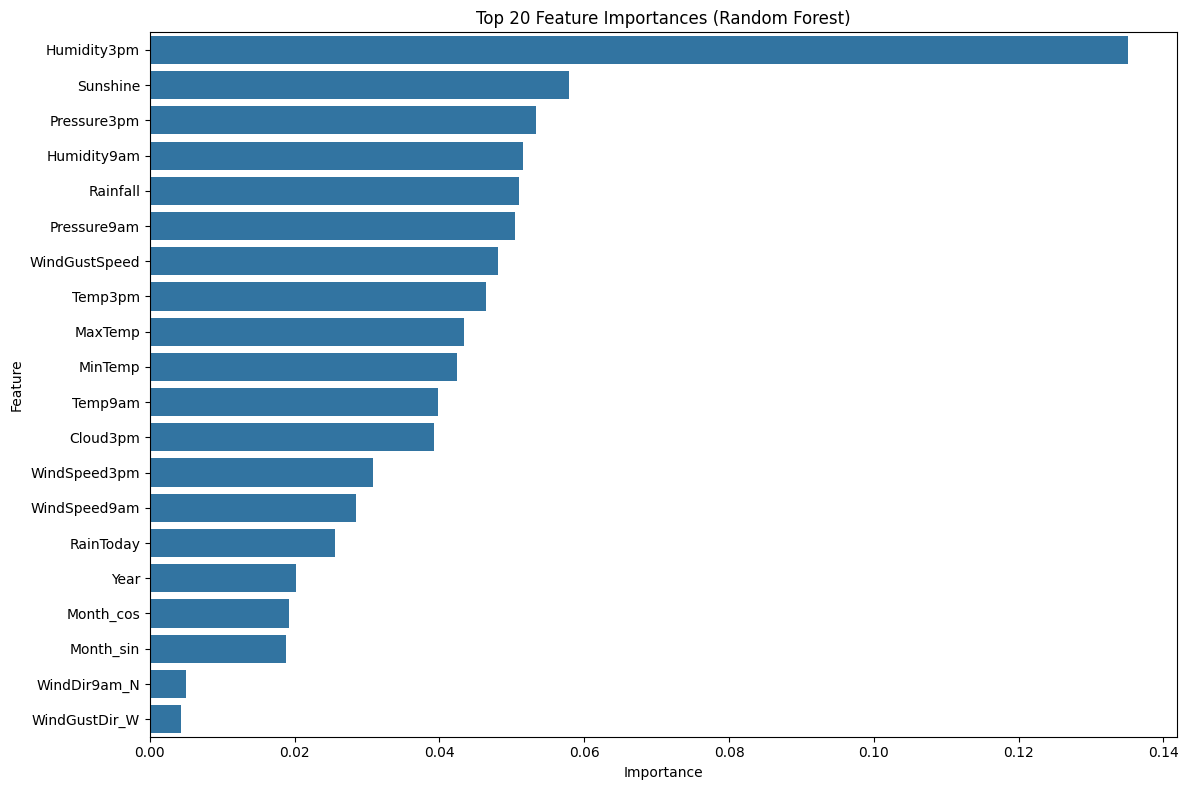

In [123]:
import seaborn as sns

# Get the trained Random Forest model from the evaluation_results dictionary (assuming it's available)
# Access the model from the 'models' dictionary populated in cell 0f6b9da1
random_forest_model = models['Random Forest']

# Get feature importances from the trained model
feature_importances = random_forest_model.feature_importances_

# Get the names of the features.
# Assuming X_train (from cell dbd60573) contains the feature names in the correct order
# as they were passed to the model after preprocessing.
feature_names = X_train.columns

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
print("Top 20 Feature Importances:")
display(feature_importance_df.head(20))

# Visualize the top 20 feature importances using a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (Random Forest)') # Set the title of the plot
plt.xlabel('Importance') # Label for the x-axis
plt.ylabel('Feature') # Label for the y-axis
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show() # Display the plot

## Confusion Matrix:

A confusion matrix is a 2x2 table showing True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN). It is the foundation for most of the metrics above and offers a direct visualization of prediction breakdowns.

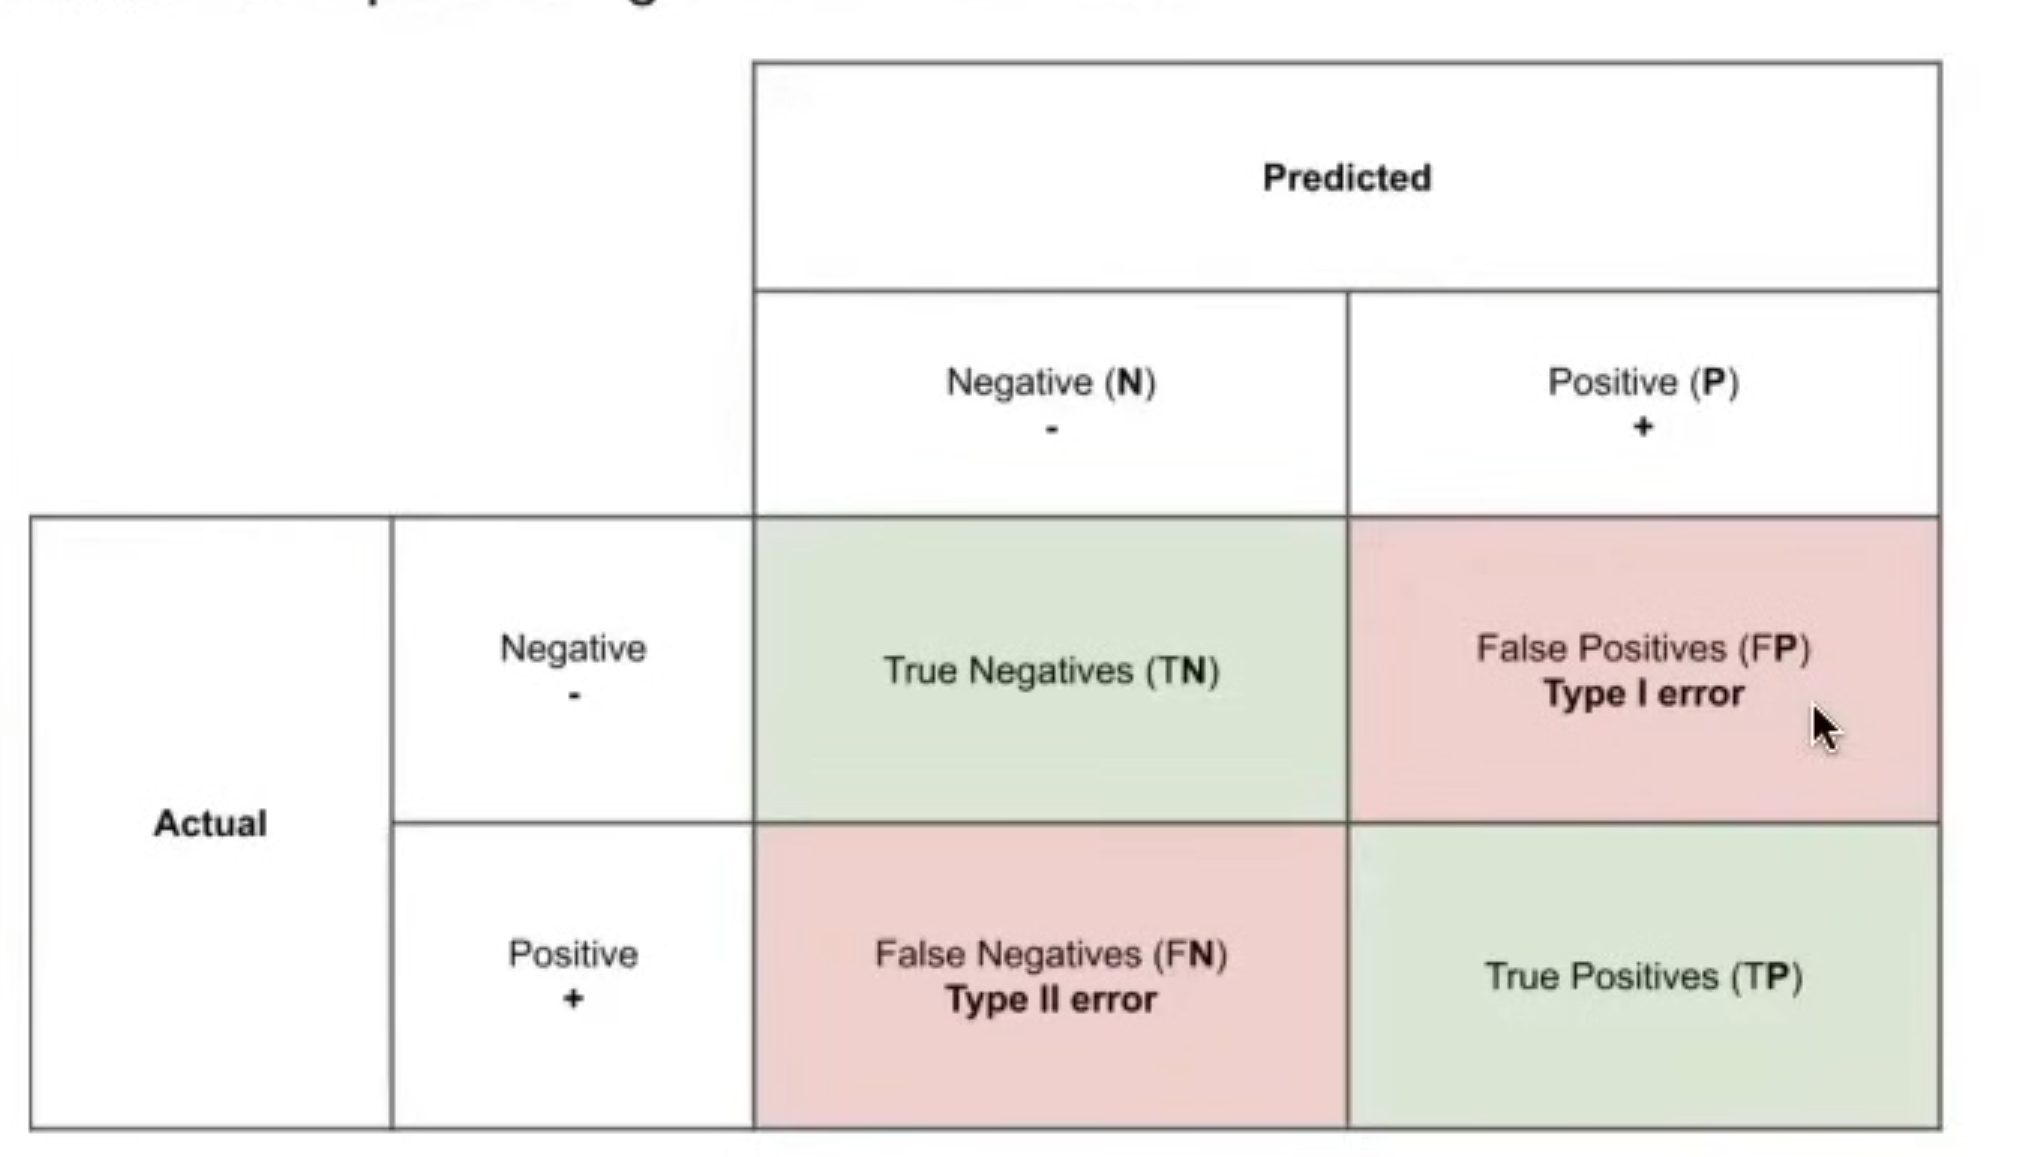

In [124]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the trained Random Forest model from the evaluation_results dictionary
# Assuming the evaluation_results dictionary is available from cell 0f6b9da1
random_forest_model = models['Random Forest']

# Generate predictions on the validation set using the trained model
y_pred_rf = random_forest_model.predict(X_val)

# Generate the confusion matrix
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(conf_matrix_rf)

# Generate the classification report
class_report_rf = classification_report(y_val, y_pred_rf)
print("\nClassification Report (Random Forest):")
print(class_report_rf)

Confusion Matrix (Random Forest):
[[26897  1091]
 [ 4322  3509]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     27988
         1.0       0.76      0.45      0.56      7831

    accuracy                           0.85     35819
   macro avg       0.81      0.70      0.74     35819
weighted avg       0.84      0.85      0.83     35819



Normalized Confusion Matrix (Random Forest - Probabilities per True Class):
[[0.96101901 0.03898099]
 [0.55190908 0.44809092]]


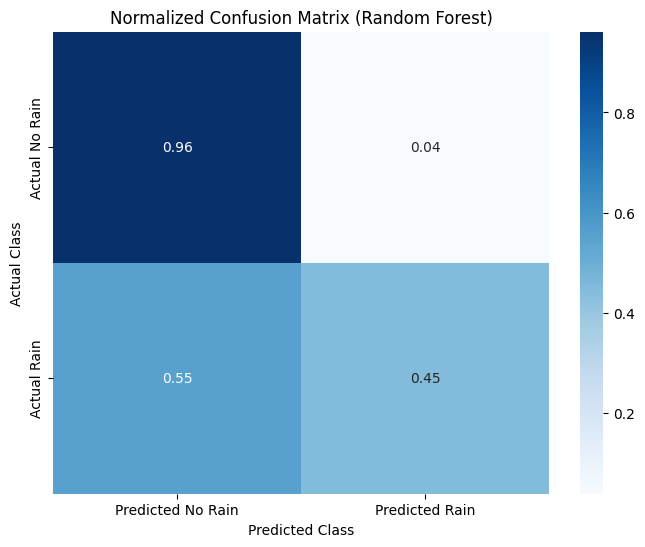

In [125]:
# Get the trained Random Forest model from the evaluation_results dictionary
# Assuming 'random_forest_model' is the fitted model from cell 0f6b9da1
random_forest_model = models['Random Forest']

# Generate predictions on the validation set using the trained model
y_pred_rf = random_forest_model.predict(X_val)

# Generate the confusion matrix (counts)
conf_matrix_rf = confusion_matrix(y_val, y_pred_rf)

# Normalize the confusion matrix by row (to get percentages of true classes)
# This shows the recall for each class
conf_matrix_normalized = conf_matrix_rf.astype('float') / conf_matrix_rf.sum(axis=1)[:, np.newaxis]

print("Normalized Confusion Matrix (Random Forest - Probabilities per True Class):")
print(conf_matrix_normalized)

# Optional: Visualize the normalized confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Predicted No Rain', 'Predicted Rain'],
            yticklabels=['Actual No Rain', 'Actual Rain'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Normalized Confusion Matrix (Random Forest)')
plt.show()

## ROC Curve and AUC

The Receiver Operating Characteristic (ROC) curve plots the true positive rate (recall) against the false positive rate at various thresholds, providing a way to visualize performance across thresholds. The Area Under the Curve (AUC) quantifies this; an AUC of 1.0 means perfect separation, while 0.5 indicates no predictive power.​

AUC-ROC is especially useful for comparing models and is robust against class imbalance.

In [134]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming models dictionary and X_val, y_val are available from previous cells

fig = go.Figure()

# Iterate through each model, calculate ROC curve and AUC, and add to plot
for model_name, model in models.items():
    # Get the predicted probabilities for the positive class (class 1)
    y_prob = model.predict_proba(X_val)[:, 1]

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_val, y_prob)

    # Add ROC curve to the plot
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines',
                             name=f'{model_name} (AUC = {auc_score:.4f})'))

# Add random guessing line
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_layout(
    title='ROC Curves for Binary Classification Models (Interactive)',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]), # Set scaleanchor and scaleratio for square aspect
    legend_title='Model',
    width=800,  # Set overall width
    height=600  # Set overall height
)

fig.show()

# Print AUC scores for clarity (optional, as they are in the legend)
print("AUC Scores:")
for model_name, model in models.items():
     y_prob = model.predict_proba(X_val)[:, 1]
     auc_score = roc_auc_score(y_val, y_prob)
     print(f"  {model_name}: {auc_score:.4f}")

AUC Scores:
  Logistic Regression: 0.8548
  Decision Tree: 0.6767
  Random Forest: 0.8681


**ROC Curve and AUC Analysis**

The ROC (Receiver Operating Characteristic) curve is a performance metric for binary classification problems. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The Area Under the ROC Curve (AUC) is a single scalar value that summarizes the overall performance of a binary classifier; an AUC of 1 indicates a perfect classifier, while an AUC of 0.5 indicates a classifier no better than random guessing.

Looking at the ROC curves plotted above:

*   The **Random Forest** model has the highest AUC score (approximately 0.8681), indicating it has the best overall ability to distinguish between days with and without rain tomorrow among the evaluated models. Its curve is closest to the top-left corner, signifying a good trade-off between TPR and FPR across different thresholds.
*   The **Logistic Regression** model has the second-highest AUC score (approximately 0.8548), showing good performance but slightly less discriminatory power than the Random Forest.
*   The **Decision Tree** model has the lowest AUC score (approximately 0.6767), indicating weaker performance compared to the other two models in separating the classes. Its curve is closer to the diagonal line representing random guessing.

In summary, the Random Forest model's higher AUC score and its ROC curve's position suggest it is the most effective model for this binary classification task based on the evaluated metrics.